In [1]:
#describe each location with companies in side
import pandas as pd
import numpy as np
import os
import pygeohash as pgh
from math import *
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics import precision_recall_curve, roc_curve, auc
import random
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
from sklearn.linear_model import LogisticRegression as LR
pjoin = os.path.join


In [30]:
#data load
datapath = '/Users/yefeichen/Database/location_recommender_system/'
cfile = ['dnb_pa.csv','dnb_sf.csv','dnb_sj.csv']
lfile = 'location_scorecard_190912.csv'
clfile = ['PA.csv','SF.csv','SJ.csv']
lfile_app = ['PA_comp_loc_score.csv','SF_comp_loc_score.csv','SJ_comp_loc_score.csv']
testfile = 'train_val_test_location_company_all.csv'

Query_Company = False

ind_city = 1

comp_feat = pd.read_csv('company_feat.csv',index_col=0)
loc_feat = pd.read_csv('location_feat.csv',index_col=0)
all_pair = pd.read_csv(testfile,index_col=0)
all_pair = all_pair[all_pair['city']==ind_city]

# ensemble_feat = pd.read_csv(lfile_app[ind_city])
ensemble_feat = pd.read_csv(lfile_app[ind_city]).sample(frac=0.5).reset_index(drop=True)

all_pair_test = all_pair[all_pair['fold']==2].reset_index(drop=True)
if Query_Company:
    pass
#     all_pair_test = all_pair_test.sort_values(by=['duns_number']).reset_index(drop=True)
else:
    all_pair_test = all_pair_test.sort_values(by=['atlas_location_uuid']).reset_index(drop=True)

dat1 = all_pair[all_pair['fold']==0]

all_company_loc = pd.read_csv(pjoin(datapath,clfile[ind_city]))[['atlas_location_uuid','duns_number']]

print('Done')

/Users/yefeichen/anaconda3/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Done


In [4]:
all_pair = pd.read_csv(testfile,index_col=0)

614

In [31]:
loc_name = all_company_loc[['atlas_location_uuid']].groupby('atlas_location_uuid')[['atlas_location_uuid']].first().reset_index(drop=True)
num_loc = len(loc_name)
print(num_loc)
# del all_company_loc

dat2 = dat1.sample(frac=1).reset_index(drop=True)
twin_dat = dat1.join(dat2, how='left', lsuffix='_left', rsuffix = '_right').reset_index(drop=True)

twin_dat = twin_dat[twin_dat['atlas_location_uuid_left'] != twin_dat['atlas_location_uuid_right']]
neg_dat1 = twin_dat[['duns_number_left', 'atlas_location_uuid_right']].reset_index(drop=True)
neg_dat1 = neg_dat1.rename(
                columns={'duns_number_left': 'duns_number', 'atlas_location_uuid_right': 'atlas_location_uuid',
                         'label_left':'label','fold_left':'fold','groundtruth_left':'groundtruth',
                        'city_left':'city'})
neg_dat1 = neg_dat1[['duns_number','atlas_location_uuid']]
neg_dat1['label'] = 0

print(neg_dat1.columns)

neg_dat2 = twin_dat[['duns_number_right', 'atlas_location_uuid_left']].reset_index(drop=True)
neg_dat2 = neg_dat2.rename(
                columns={'duns_number_right': 'duns_number', 'atlas_location_uuid_left': 'atlas_location_uuid',
                        'label_left':'label','fold_left':'fold','groundtruth_left':'groundtruth',
                        'city_left':'city'})
neg_dat2 = neg_dat2[['duns_number','atlas_location_uuid']]
neg_dat2['label'] = 0

pos_dat = dat1[['duns_number', 'atlas_location_uuid', 'label']]
# del dat1,dat2

train_dat = pd.concat([pos_dat, neg_dat1,neg_dat2], axis=0)
train_dat = train_dat.sample(frac=1).reset_index(drop=True)
print('Done')

1439
Index(['duns_number', 'atlas_location_uuid', 'label'], dtype='object')
Done


In [32]:
print('get train feat')
trX = train_dat.merge(comp_feat,on='duns_number',how='left',suffixes=['','_right']).reset_index(drop=True)
trX = trX.merge(loc_feat,on='atlas_location_uuid',how='left',suffixes=['','_right']).reset_index(drop=True)
trX = trX.merge(ensemble_feat,on=['atlas_location_uuid','duns_number'],how='left',suffixes=['','_right']).reset_index(drop=True)
trX = trX.fillna(0.5)
list_col = list(comp_feat.columns)+list(loc_feat.columns)+list(ensemble_feat.columns)
list_col = [col for col in list_col if col not in ['duns_number', 'atlas_location_uuid', 'label']]
trY = trX[['label']].to_numpy()
trX = trX[list_col].to_numpy()

print('get test feat')
ttX = all_pair_test[['duns_number','atlas_location_uuid']].merge(comp_feat,on='duns_number',how='left',suffixes=['','_right']).reset_index(drop=True)
ttX = ttX.merge(loc_feat,on='atlas_location_uuid',how='left',suffixes=['','_right']).reset_index(drop=True)
ttX = ttX.merge(ensemble_feat,on=['atlas_location_uuid','duns_number'],how='left',suffixes=['','_right']).reset_index(drop=True)
ttX = ttX.fillna(0.5)
list_col = list(comp_feat.columns)+list(loc_feat.columns)+list(ensemble_feat.columns)
list_col = [col for col in list_col if col not in ['duns_number', 'atlas_location_uuid', 'label']]
ttX = ttX[list_col].to_numpy()
ttY = (all_pair_test['atlas_location_uuid'] == all_pair_test['groundtruth']).to_numpy() + 0
# del all_pair_test

# trX[:,-1] = 0
# ttX[:,-1] = 0
print('train normalization')
trX = normalize(trX,axis=1)
print('test normalization')
ttX = normalize(ttX,axis=1)

print('training')
# clf = LR(random_state=0,fit_intercept=True,
#          solver = 'lbfgs',class_weight='balanced',
#          multi_class='ovr',max_iter=1e10).fit(trX,trY)
clf = LR(random_state=0,fit_intercept=True,
         solver = 'lbfgs',
         multi_class='ovr',max_iter=1e10).fit(trX,trY)

print('predicting')
score_ttY = clf.predict_proba(ttX)[:,1]

print('roc curving')
fpr, tpr, roc_thresholds = roc_curve(ttY, score_ttY)
roc_auc = auc(fpr,tpr)
print(roc_auc)
print('Done')

get train feat
get test feat
train normalization
test normalization
training


/Users/yefeichen/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


predicting
roc curving
0.6212124402087643
Done


In [33]:
del ttX,trX
prediction = score_ttY.copy()
groundtruth = ttY.copy()

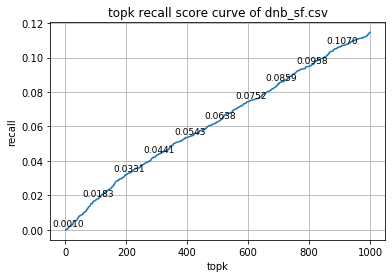

In [34]:
if Query_Company:
    score_ttY = prediction.reshape(-1,num_loc)
    ttY = groundtruth.reshape(-1,num_loc)
else:
    score_ttY = prediction.reshape(num_loc,-1)
    ttY = groundtruth.reshape(num_loc,-1)
    
    
topk = 1000
step = int(topk / 10)
topk_recall = topk_recall_score_all(pred=score_ttY, truth=ttY, topk=topk)


# score_ttY = score_ttY.reshape(-1,num_loc)
# # groundtruth = all_pair_test[['duns_number','groundtruth']].groupby(['duns_number','groundtruth'])[['groundtruth']].first().reset_index(drop=True).to_numpy()
# # R_cat = loc_name.to_numpy().reshape(-1)
# # topk_precision = calc_topk_acc_cat_all(score_ttY,groundtruth,R_cat,k=100)
# ttY = ttY.reshape(-1,num_loc)
# truth_cat = one_hot_2_idx_numpy(ttY)
# R_cat = np.array(list(range(num_loc)))

# topk = 1000
# step = 100
# topk_precision = calc_topk_acc_cat_all(score_ttY,truth_cat,R_cat,k=topk)



x = list(range(1,topk+1))
y = list(topk_recall.reshape(-1))
plt.figure()
plt.plot(x,y)

plt.grid()

for z in range(10,topk+1,step):
    z = z - 1
    plt.text(z, y[z], '%.4f' % y[z], ha='center', va= 'bottom',fontsize=9)

plt.xlabel("topk")
plt.ylabel("recall")
plt.title("topk recall score curve of %s"%cfile[ind_city])
plt.show()


In [4]:
def calc_topk_acc_cat_all(QRscore,y_truth_cat,R_cat,k=3):
    """
    QRscore: similarity score matrix shape [Q,R]
    y_truth: index(related with R) of truth label of Query
    return top1-topk acc
    """
    res = []
    y_truth_cat = y_truth_cat.reshape(-1,1)
    max_k_preds = QRscore.argsort(axis=1)[:, -k:][:, ::-1] #得到top-k max label
    max_k_cat = R_cat[max_k_preds]
    M = max_k_cat==y_truth_cat
    for k in range(M.shape[1]):
        match_array = np.logical_or.reduce(M[:,:k+1], axis=1) #得到匹配结果
        topk_acc_score = match_array.sum() / match_array.shape[0]
        res.append(topk_acc_score)
    return res

def one_hot_2_idx(y_one_hot):
    """
    y_one_hot:FloatTensor shape:[batch_size, nCls]
    y_idx: LongTensor shape:[batch_size,1]
    """
    _,idx_mat = torch.max(y_one_hot,1,keepdim=False)
    y_idx = idx_mat.view(-1,1)
    return y_idx

def one_hot_2_idx_numpy(y_one_hot):
    """
    y_one_hot:FloatTensor shape:[batch_size, nCls]
    y_idx: LongTensor shape:[batch_size,1]
    """
    idx_mat = np.argmax(y_one_hot,1)
    y_idx = idx_mat.reshape(-1,1)
    return y_idx

def topk_recall_score_all(pred,truth,topk=5):
    """
    N: sample number
    M: class number
    pred [N,M] 
    truth [N,M]
    large value of score means 1 in truth, while small value of score means 0 in truth.
    return each topL(L<=topk) average recall_score 
    """
    N,M = pred.shape
    _N,_M = truth.shape
    assert( M==_M and N==_N )
    #get rank of the predicted score, acsending
    rank_of_pred = np.argsort(pred,axis=1)
    #get topk ranked label
    ranked_label = np.take_along_axis(truth,rank_of_pred,axis=1)[:,-1:-topk-1:-1]#[N,topk]
    nTruth = truth.sum(axis=1).reshape(-1,1)#[N,1]
    nTruth[nTruth<1]=1
    ranked_label = ranked_label/nTruth
    recall_score = np.cumsum(ranked_label.sum(axis=0).reshape(1,-1),axis=1)
    # nTruth = truth.sum(axis=1).reshape(1,-1)
    # nTop = np.array(range(topk)).reshape(1,topk) + 1
    recall_score = (recall_score / N)
    return recall_score

In [8]:
best_auc = 0
for lp in range(10):
    loc_name = all_company_loc[['atlas_location_uuid']].groupby('atlas_location_uuid')[['atlas_location_uuid']].first().reset_index(drop=True)
    num_loc = len(loc_name)
    print(num_loc)
    # del all_company_loc

    dat2 = dat1.sample(frac=1).reset_index(drop=True)
    twin_dat = dat1.join(dat2, how='left', lsuffix='_left', rsuffix = '_right').reset_index(drop=True)

    twin_dat = twin_dat[twin_dat['atlas_location_uuid_left'] != twin_dat['atlas_location_uuid_right']]
    neg_dat1 = twin_dat[['duns_number_left', 'atlas_location_uuid_right']].reset_index(drop=True)
    neg_dat1 = neg_dat1.rename(
                    columns={'duns_number_left': 'duns_number', 'atlas_location_uuid_right': 'atlas_location_uuid',
                             'label_left':'label','fold_left':'fold','groundtruth_left':'groundtruth',
                            'city_left':'city'})
    neg_dat1 = neg_dat1[['duns_number','atlas_location_uuid']]
    neg_dat1['label'] = 0

    print(neg_dat1.columns)

    # neg_dat2 = twin_dat[['duns_number_right', 'atlas_location_uuid_left']].reset_index(drop=True)
    # neg_dat2 = neg_dat2.rename(
    #                 columns={'duns_number_right': 'duns_number', 'atlas_location_uuid_left': 'atlas_location_uuid'})
    # neg_dat2 = neg_dat2[['duns_number','atlas_location_uuid']]
    # neg_dat2['label'] = 0

    pos_dat = dat1[['duns_number', 'atlas_location_uuid', 'label']]
    # del dat1,dat2

    train_dat = pd.concat([pos_dat, neg_dat1], axis=0)
    train_dat = train_dat.sample(frac=1).reset_index(drop=True)
    print('Done')
    trX = train_dat.merge(comp_feat,on='duns_number',how='left',suffixes=['','_right']).reset_index(drop=True)
    trX = trX.merge(loc_feat,on='atlas_location_uuid',how='left',suffixes=['','_right']).reset_index(drop=True)
    trX = trX.merge(ensemble_feat,on=['atlas_location_uuid','duns_number'],how='left',suffixes=['','_right']).reset_index(drop=True)
    list_col = list(comp_feat.columns)+list(loc_feat.columns)+list(ensemble_feat.columns)
    list_col = [col for col in list_col if col not in ['duns_number', 'atlas_location_uuid', 'label']]
    trY = trX[['label']].to_numpy()
#     trX['sim_score'] = 0
    trX = trX[list_col].to_numpy()

    ttX = all_pair_test[['duns_number','atlas_location_uuid']].merge(comp_feat,on='duns_number',how='left',suffixes=['','_right']).reset_index(drop=True)
    ttX = ttX.merge(loc_feat,on='atlas_location_uuid',how='left',suffixes=['','_right']).reset_index(drop=True)
    ttX = ttX.merge(ensemble_feat,on=['atlas_location_uuid','duns_number'],how='left',suffixes=['','_right']).reset_index(drop=True)
    list_col = list(comp_feat.columns)+list(loc_feat.columns)+list(ensemble_feat.columns)
    list_col = [col for col in list_col if col not in ['duns_number', 'atlas_location_uuid', 'label']]
#     ttX['sim_score'] = 0
    ttX = ttX[list_col].to_numpy()
    ttY = (all_pair_test['atlas_location_uuid'] == all_pair_test['groundtruth']).to_numpy() + 0
    # del all_pair_test

    clf = LR(random_state=0,fit_intercept=True,
             solver = 'lbfgs',class_weight='balanced',
             multi_class='ovr',max_iter=1e10).fit(trX,trY)

    score_ttY = clf.predict_proba(ttX)[:,1]


    fpr, tpr, roc_thresholds = roc_curve(ttY, score_ttY)
    roc_auc = auc(fpr,tpr)
    print(roc_auc)
    print('Done')
    if roc_auc > best_auc:
        best_clf = clf
    

352
Index(['duns_number', 'atlas_location_uuid', 'label'], dtype='object')
Done


/Users/yefeichen/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.552907933401182
Done
352
Index(['duns_number', 'atlas_location_uuid', 'label'], dtype='object')
Done


/Users/yefeichen/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.544006404843891
Done
352
Index(['duns_number', 'atlas_location_uuid', 'label'], dtype='object')
Done


/Users/yefeichen/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.5410039662793719
Done
352
Index(['duns_number', 'atlas_location_uuid', 'label'], dtype='object')
Done


/Users/yefeichen/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.5549706039820648
Done
352
Index(['duns_number', 'atlas_location_uuid', 'label'], dtype='object')
Done


/Users/yefeichen/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.564710760052904
Done
352
Index(['duns_number', 'atlas_location_uuid', 'label'], dtype='object')
Done


/Users/yefeichen/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.5564641960305777
Done
352
Index(['duns_number', 'atlas_location_uuid', 'label'], dtype='object')
Done


/Users/yefeichen/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.5418813043514504
Done
352
Index(['duns_number', 'atlas_location_uuid', 'label'], dtype='object')
Done


/Users/yefeichen/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.5466248638291163
Done
352
Index(['duns_number', 'atlas_location_uuid', 'label'], dtype='object')
Done


/Users/yefeichen/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.5315319618760701
Done
352
Index(['duns_number', 'atlas_location_uuid', 'label'], dtype='object')
Done


/Users/yefeichen/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.5171374166615634
Done


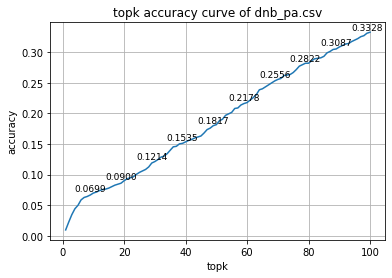

In [9]:
score_ttY = best_clf.predict_proba(ttX)[:,1]


fpr, tpr, roc_thresholds = roc_curve(ttY, score_ttY)
roc_auc = auc(fpr,tpr)

score_ttY = score_ttY.reshape(-1,num_loc)
# groundtruth = all_pair_test[['duns_number','groundtruth']].groupby(['duns_number','groundtruth'])[['groundtruth']].first().reset_index(drop=True).to_numpy()
# R_cat = loc_name.to_numpy().reshape(-1)
# topk_precision = calc_topk_acc_cat_all(score_ttY,groundtruth,R_cat,k=100)
ttY = ttY.reshape(-1,num_loc)
truth_cat = one_hot_2_idx_numpy(ttY)
R_cat = np.array(list(range(num_loc)))

topk = 100
topk_precision = calc_topk_acc_cat_all(score_ttY,truth_cat,R_cat,k=topk)



x = list(range(1,topk+1))
y = list(topk_precision)
plt.figure()
plt.plot(x,y)

plt.grid()

for z in range(10,topk+1,10):
    z = z - 1
    plt.text(z, y[z], '%.4f' % y[z], ha='center', va= 'bottom',fontsize=9)

plt.xlabel("topk")
plt.ylabel("accuracy")
plt.title("topk accuracy curve of %s"%cfile[ind_city])
plt.show()


In [3]:
all_pair_test.head()

,duns_number,atlas_location_uuid,label,fold,groundtruth,city
0,2127360.0,003fd16c-0dee-24a1-1adf-0b47d6120f3d,NaN,2,7a687b49-1055-24f6-ae84-e390438fe3c4,0
1,2127360.0,0060ef47-b121-60b9-1983-02ebdb144dcf,NaN,2,7a687b49-1055-24f6-ae84-e390438fe3c4,0
2,2127360.0,0084ae4b-c24c-0795-d1e6-a4f58444d39b,NaN,2,7a687b49-1055-24f6-ae84-e390438fe3c4,0
3,2127360.0,00a68dc6-f955-c581-9a54-64404bb0ef6a,NaN,2,7a687b49-1055-24f6-ae84-e390438fe3c4,0
4,2127360.0,01109439-6b76-0fc9-2d96-cfdb79708a80,NaN,2,7a687b49-1055-24f6-ae84-e390438fe3c4,0


In [17]:
all_pair_test = all_pair_test.sort_values(by=['atlas_location_uuid']).reset_index(drop=True)

In [18]:
all_pair_test.head()

,duns_number,atlas_location_uuid,label,fold,groundtruth,city
0,2127360.0,003fd16c-0dee-24a1-1adf-0b47d6120f3d,NaN,2,7a687b49-1055-24f6-ae84-e390438fe3c4,0
1,116055488.0,003fd16c-0dee-24a1-1adf-0b47d6120f3d,NaN,2,0cd6a652-ed1f-7811-192d-b1f700c8f0e7,0
2,33493534.0,003fd16c-0dee-24a1-1adf-0b47d6120f3d,NaN,2,e0912f72-3407-15f8-2772-65f104acd4b7,0
3,116937846.0,003fd16c-0dee-24a1-1adf-0b47d6120f3d,NaN,2,d3d3cccf-2f3c-18dc-0b00-69151a62a0fe,0
4,80999593.0,003fd16c-0dee-24a1-1adf-0b47d6120f3d,NaN,2,5246fec2-c62b-11e9-997c-3af9d322409d,0


In [43]:
(y**2).sum(axis=1)

array([1., 1., 1.])

In [11]:
#data load
datapath = '/Users/yefeichen/Database/location_recommender_system/'
testfile = 'train_val_test_location_company_all.csv'

ind_city = 0

all_pair = pd.read_csv(testfile,index_col=0)
all_pair = all_pair[all_pair['city']==ind_city]

all_pair_test = all_pair[all_pair['fold']==2].reset_index(drop=True)
dat1 = all_pair[all_pair['fold']==0]

print(len(all_pair_test))

437888


In [8]:
print(len(dat1))

20032


In [12]:
all_pair.head()

,duns_number,atlas_location_uuid,label,fold,groundtruth,city
0,47209759.0,ab4f2b5f-d96c-a653-4911-9909c1eada2d,1.0,0,NaN,0
1,79819894.0,b89c3096-5ebc-7491-2de8-79f22da62dbf,1.0,0,NaN,0
2,104144451.0,35e7d0aa-2bae-a744-8e38-4bb1d05df06a,1.0,0,NaN,0
3,34152094.0,ebf12cb7-4e96-e67e-6378-3d93c534ef27,1.0,0,NaN,0
4,25198688.0,09ffac1a-62f6-d5b6-20ff-2499465b65c6,1.0,0,NaN,0
